In [1]:
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import cv2
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
import time
import csv
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


0: 480x640 1 person, 114.5ms
Speed: 10.0ms preprocess, 114.5ms inference, 247.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bottle, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bottle, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 24.0ms
Speed: 3.0ms preprocess, 24.0ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 21.5ms
Speed: 3.0ms preprocess, 21.5ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 21.0ms
Speed: 3.0ms preprocess, 21.0ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 23.6ms
Speed: 3.0ms preprocess, 23.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bottle, 24.0ms
Speed: 11.8ms preprocess, 24.0ms inference, 3.0ms post

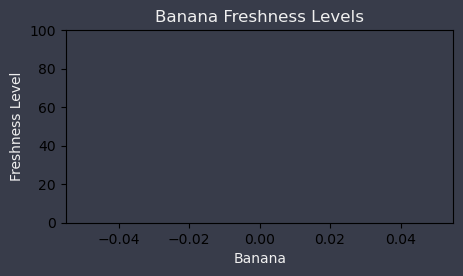

In [2]:
 
yolo_model = YOLO('yolov8n.pt')   

# Load EfficientNet for classification
def load_efficientnet_model(checkpoint_path, num_classes=3):
    model = models.efficientnet_b0(weights="IMAGENET1K_V1")
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

efficientnet_model = load_efficientnet_model('new1_bannana_efficientnet_layerupdated.pt', num_classes=3)

 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

 
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
    'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'TV', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

 
def classify_banana(image, model):
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

 
def save_to_csv(freshness_data):
    file_exists = os.path.isfile('freshness.csv')
    with open('freshness.csv', 'a', newline='') as csvfile:
        fieldnames = ['Banana_ID', 'Freshness', 'Shelf_Life']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()   
        
        for i, freshness in enumerate(freshness_data):
            timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
            shelf_life = "1 week" if freshness == 0 else "0 days" if freshness == 1 else "2 weeks"
            writer.writerow({'Banana_ID': timestamp, 'Freshness': {0: 'ripe', 1: 'rotten', 2: 'unripe'}[freshness], 'Shelf_Life': shelf_life})

 
class BananaFreshnessApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Banana Freshness Detection")
        self.root.geometry("1200x800")
        self.root.configure(bg="#282C34")

 
        frame_bg = "#383C4A"
        widget_fg = "#F0F0F0"

 
        self.main_frame = tk.Frame(self.root, bg=frame_bg)
        self.main_frame.pack(fill="both", expand=True, padx=10, pady=10)

 
        self.camera_frame = tk.Frame(self.main_frame, bg=frame_bg, width=700, height=600)
        self.camera_frame.grid(row=0, column=0, rowspan=2, padx=10, pady=10, sticky="nsew")

        self.video_label = tk.Label(self.camera_frame, bg=frame_bg, fg=widget_fg, text="Camera Feed", font=("Helvetica", 12))
        self.video_label.pack(fill="both", expand=True)

 
        self.graph_frame = tk.Frame(self.main_frame, bg=frame_bg)
        self.graph_frame.grid(row=0, column=1, padx=10, pady=10, sticky="nsew")

 
        self.fig, self.ax = plt.subplots(figsize=(5, 2.5), facecolor=frame_bg)
        self.ax.set_facecolor(frame_bg)
        self.bar_chart = FigureCanvasTkAgg(self.fig, master=self.graph_frame)
        self.bar_chart.get_tk_widget().pack(pady=10, padx=10)

 
        self.table_frame = tk.Frame(self.main_frame, bg=frame_bg)
        self.table_frame.grid(row=1, column=1, padx=10, pady=10, sticky="nsew")

 
        self.shelf_life_table = ttk.Treeview(self.table_frame, columns=("Banana", "Shelf Life"), show="headings", height=5)
        self.shelf_life_table.heading("Banana", text="Banana")
        self.shelf_life_table.heading("Shelf Life", text="Shelf Life")
        self.shelf_life_table.column("Banana", anchor='center')
        self.shelf_life_table.column("Shelf Life", anchor='center')
        self.shelf_life_table.pack(pady=5, padx=5)
 
        style = ttk.Style()
        style.configure("Treeview.Heading", font=("Helvetica", 10, "bold"), background="#4CAF50", foreground="black")
        style.configure("Treeview", rowheight=30, font=("Helvetica", 10), background="#f9f9f9", foreground="#000000", fieldbackground="#f9f9f9")
        
 
        save_button = tk.Button(self.main_frame, text="Save Results", font=("Helvetica", 12), bg="#4CAF50", fg="white", command=self.save_results)
        save_button.grid(row=2, column=0, padx=10, pady=10)

 
        self.cap = cv2.VideoCapture(0)
        self.update()

    def plot_freshness(self, freshness_data):
 
        self.ax.clear()

 
        labels = [f"Banana {i+1}" for i in range(len(freshness_data))]
        values = [100 if f == 2 else 60 if f == 0 else 10 for f in freshness_data]

 
        colors = ['#4CAF50' if f == 0 else '#FF9800' if f == 1 else '#F44336' for f in freshness_data]

 
        self.ax.bar(labels, values, color=colors)
        self.ax.set_ylim([0, 100])
        self.ax.set_ylabel("Freshness Level", fontsize=10, color="#F0F0F0")
        self.ax.set_xlabel("Banana", fontsize=10, color="#F0F0F0")
        self.ax.set_title("Banana Freshness Levels", fontsize=12, color="#F0F0F0")

 
        self.bar_chart.draw()

    def update_shelf_life_table(self, freshness_data):
 
        for row in self.shelf_life_table.get_children():
            self.shelf_life_table.delete(row)

 
        for i, freshness in enumerate(freshness_data):
            shelf_life = "1 week" if freshness == 0 else "0 days" if freshness == 1 else "2 weeks"
            self.shelf_life_table.insert("", "end", values=(f"Banana {i+1}", shelf_life))

    def update(self):
        ret, frame = self.cap.read()
        if ret:
            frame = cv2.flip(frame, 1)   
            results = yolo_model(frame, conf=0.3)
            detections = results[0].boxes
            detected_classes = detections.cls.cpu().numpy()
            detected_class_names = [COCO_CLASSES[int(cls)] for cls in detected_classes]

            banana_detections = []   

            for i in range(len(detections)):
                xyxy = detections.xyxy[i].cpu().numpy()
                class_name = detected_class_names[i]
                if class_name == "banana":
                    banana_detections.append(xyxy)

            freshness_data = []   
            if len(banana_detections) > 0:
                for idx, xyxy in enumerate(banana_detections):
                    x1, y1, x2, y2 = map(int, xyxy)
                    banana_crop = frame[y1:y2, x1:x2]
                    banana_crop_pil = Image.fromarray(cv2.cvtColor(banana_crop, cv2.COLOR_BGR2RGB))
                    label = classify_banana(banana_crop_pil, efficientnet_model)
                    freshness_data.append(label)

 
                    label_text = {0: "ripe", 1: "rotten", 2: "unripe"}[label]
                    colors = {0: (0, 255, 0), 1: (255, 165, 0), 2: (255, 0, 0)}  # Fresh: Green, Ripe: Orange, Rotten: Red
                    cv2.rectangle(frame, (x1, y1), (x2, y2), colors[label], 2)
                    cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

 
                self.plot_freshness(freshness_data)
                self.update_shelf_life_table(freshness_data)
                save_to_csv(freshness_data)   
            else:
 
                self.plot_freshness([])
                self.update_shelf_life_table([])

 
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            imgtk = ImageTk.PhotoImage(image=img)
            self.video_label.imgtk = imgtk
            self.video_label.configure(image=imgtk)

 
        self.root.after(10, self.update)

    def save_results(self):
        ret, frame = self.cap.read()
        if ret:
            file_name = filedialog.asksaveasfilename(defaultextension=".jpg", filetypes=[("JPEG", "*.jpg"), ("PNG", "*.png")])
            if file_name:
                cv2.imwrite(file_name, frame)
                messagebox.showinfo("Success", "Image saved successfully!")

    def on_closing(self):
        self.cap.release()
        self.root.destroy()

 
root = tk.Tk()  
app = BananaFreshnessApp(root)
root.protocol("WM_DELETE_WINDOW", app.on_closing)
root.mainloop()
